In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 59.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

# Define Generator (placeholder)
class Generator(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 784),
            torch.nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)

# Define Discriminator (placeholder)
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# GAN Module
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=2e-4, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        bs = real_imgs.size(0)
        device = real_imgs.device
        z = torch.randn(bs, self.hparams.latent_dim, device=device)

        # Get the optimizers
        opt_g, opt_d = self.optimizers()

        # === Train Generator ===
        opt_g.zero_grad()
        fake_imgs = self(z)
        pred_fake = self.discriminator(fake_imgs)
        g_loss = self.adversarial_loss(pred_fake, torch.ones_like(pred_fake))
        self.manual_backward(g_loss)
        opt_g.step()
        self.log("g_loss", g_loss, prog_bar=True)

        # === Train Discriminator ===
        opt_d.zero_grad()
        pred_real = self.discriminator(real_imgs)
        loss_real = self.adversarial_loss(pred_real, torch.ones_like(pred_real))

        fake_imgs = fake_imgs.detach()
        pred_fake = self.discriminator(fake_imgs)
        loss_fake = self.adversarial_loss(pred_fake, torch.zeros_like(pred_fake))

        d_loss = (loss_real + loss_fake) / 2
        self.manual_backward(d_loss)
        opt_d.step()
        self.log("d_loss", d_loss, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1, b2 = self.hparams.b1, self.hparams.b2
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

# MNIST DataModule
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def setup(self, stage=None):
        self.mnist_train = MNIST(self.data_dir, train=True, download=True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)




In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

# Create a data module for MNIST
mnist_dm = MNISTDataModule(batch_size=64)

# Initialize the GAN model
model = GAN(latent_dim=100)

# Optional: Set up checkpointing to save model weights
checkpoint_callback = ModelCheckpoint(
    monitor="g_loss",
    save_top_k=1,
    mode="min",
    filename="gan-{epoch:02d}-{g_loss:.2f}"
)

# Initialize the trainer
trainer = Trainer(
    max_epochs=150,
    accelerator="auto",
    callbacks=[checkpoint_callback]
)

# Train the GAN
trainer.fit(model, datamodule=mnist_dm)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 114 K  | train
1 | discriminator | Discriminator | 100 K  | train
--------------------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.859     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


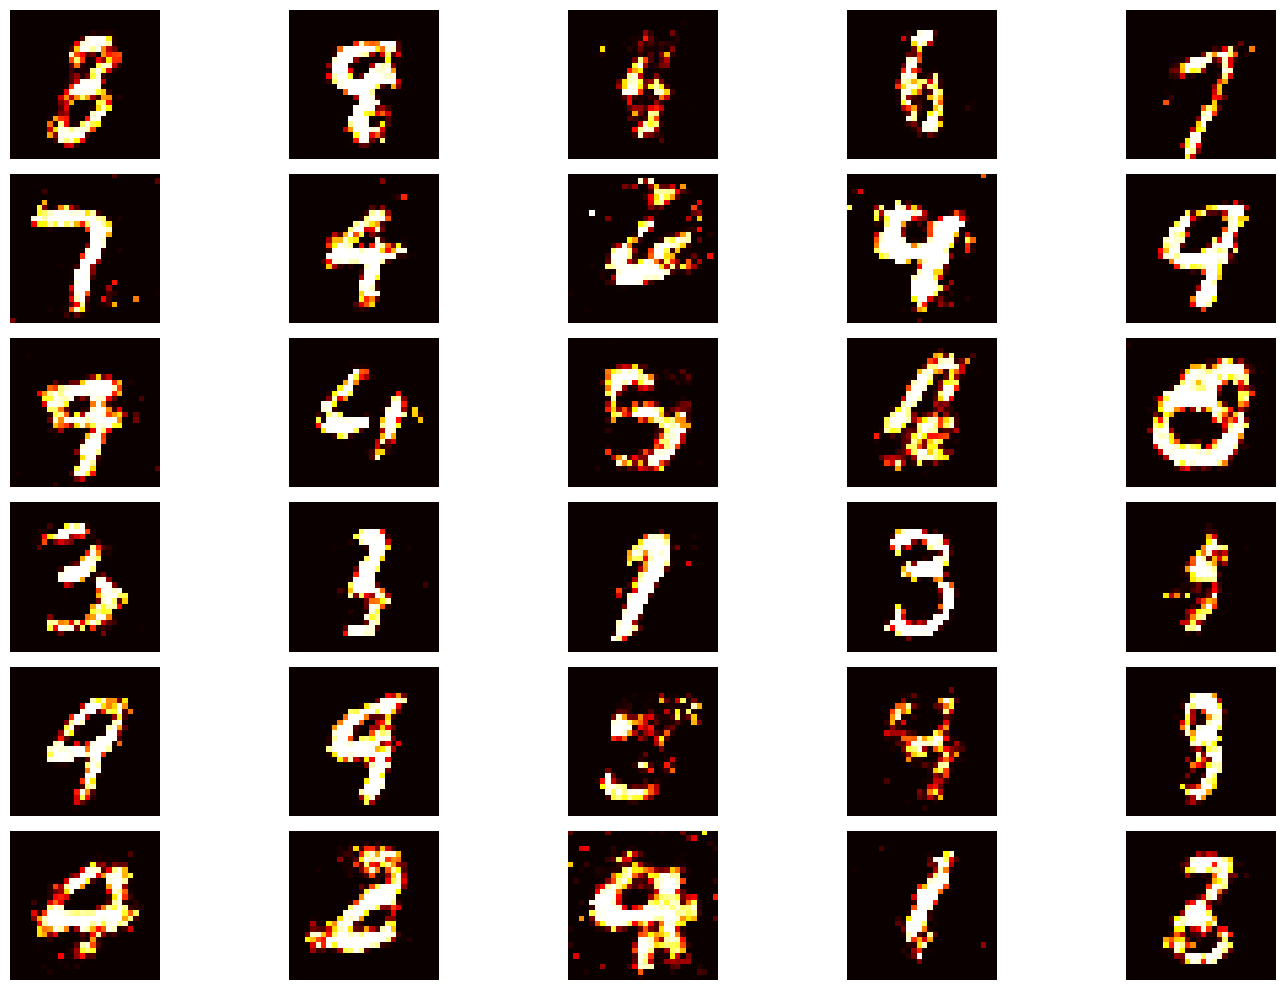

In [ ]:
import matplotlib.pyplot as plt

# Set model to eval mode and generate images
model.eval()
z = torch.randn(30, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    generated_imgs = model(z).detach().cpu()

# Unnormalize the images
generated_imgs = (generated_imgs + 1) / 2.0

# Plot the generated images
fig, axes = plt.subplots(6, 5, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes into 1D

for i, img in enumerate(generated_imgs):
    axes[i].imshow(img.squeeze(), cmap="hot")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
torch.save({
    'generator_state_dict': model.generator.state_dict(),
    'discriminator_state_dict': model.discriminator.state_dict()
}, 'gan_state.pth')


In [ ]:
model

GAN(
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=784, bias=True)
      (3): Tanh()
    )
  )
  (discriminator): Discriminator(
    (model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=1, bias=True)
      (4): Sigmoid()
    )
  )
)